# Training a Recurrent Neural Network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


In [2]:
df = pd.read_csv('data/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [3]:
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


<Axes: xlabel='Date'>

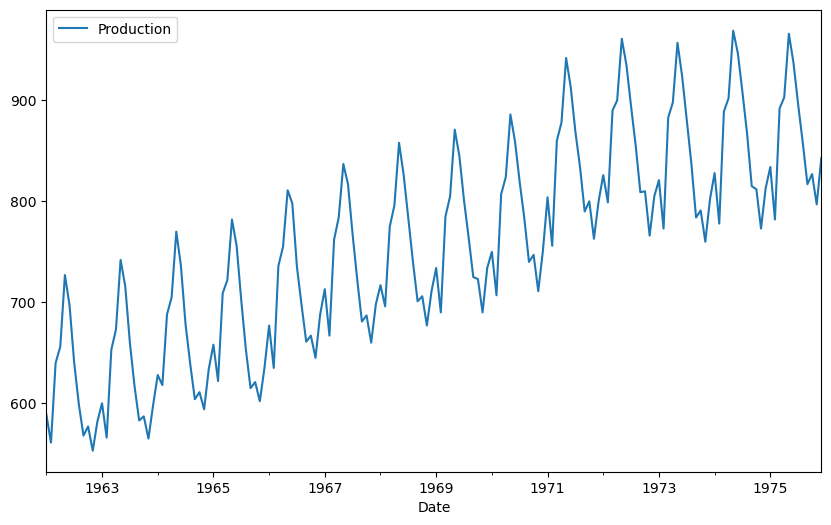

In [4]:
df.plot(figsize=(10,6))

Decomposing the variable to predict into its main components

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

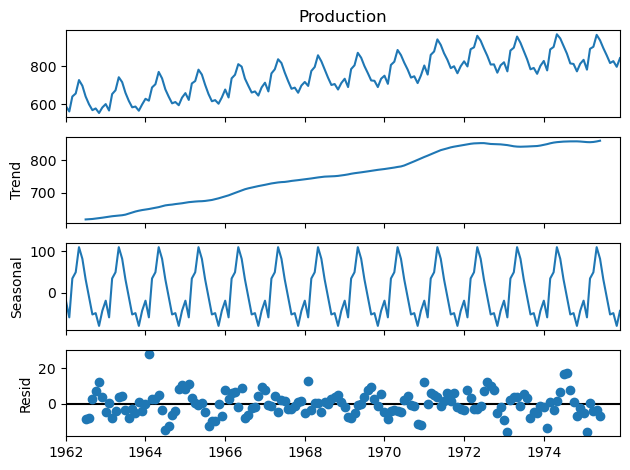

In [6]:
results = seasonal_decompose(df['Production'])
results.plot();

In [7]:
trend = results.trend
seasonal = results.seasonal
residual = results.resid

<Axes: xlabel='Date'>

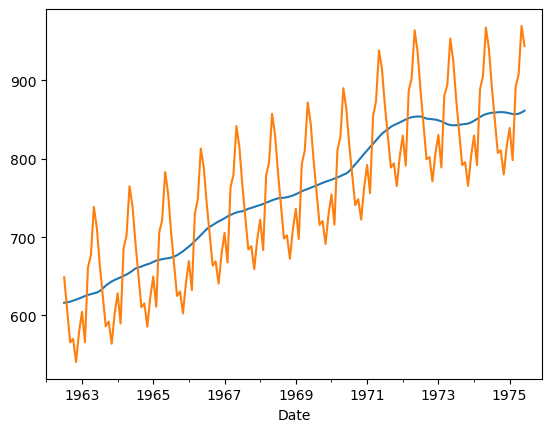

In [8]:
trend.plot()
(seasonal + trend).plot()

In [9]:
len(df)

168

In [10]:
train = df.iloc[:156]
test = df.iloc[156:]

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [12]:
df.head(),df.tail()

(            Production
 Date                  
 1962-01-01         589
 1962-02-01         561
 1962-03-01         640
 1962-04-01         656
 1962-05-01         727,
             Production
 Date                  
 1975-08-01         858
 1975-09-01         817
 1975-10-01         827
 1975-11-01         797
 1975-12-01         843)

In [13]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [14]:
scaled_train[:10]

array([[0.08653846],
       [0.01923077],
       [0.20913462],
       [0.24759615],
       [0.41826923],
       [0.34615385],
       [0.20913462],
       [0.11057692],
       [0.03605769],
       [0.05769231]])

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [16]:
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [17]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.08653846 0.01923077 0.20913462]
Predict this y: 
 [[0.24759615]]


In [18]:
generator[1]

(array([[[0.01923077],
         [0.20913462],
         [0.24759615]]]),
 array([[0.41826923]]))

In [19]:
X.shape

(1, 3, 1)

In [20]:
# We do the same thing, but now instead for 12 months
n_input = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [21]:
generator[0]

(array([[[0.08653846],
         [0.01923077],
         [0.20913462],
         [0.24759615],
         [0.41826923],
         [0.34615385],
         [0.20913462],
         [0.11057692],
         [0.03605769],
         [0.05769231],
         [0.        ],
         [0.06971154]]]),
 array([[0.11298077]]))

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN

In [23]:
# define model
model = Sequential()
model.add(SimpleRNN(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [25]:
# fit model
model.fit(generator,epochs=10)

Epoch 1/10
144/144 [==============================] - 2s 6ms/step - loss: 0.0290
Epoch 2/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0087
Epoch 3/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0078
Epoch 4/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0084
Epoch 5/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0050
Epoch 6/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 7/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0043
Epoch 8/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0028
Epoch 9/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0033
Epoch 10/10
144/144 [==============================] - 1s 6ms/step - loss: 0.0039


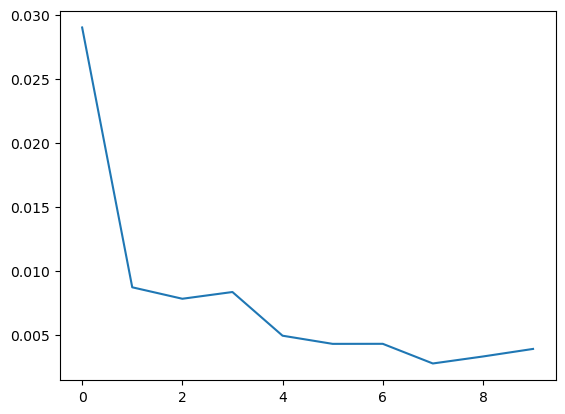

In [26]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Lets classify using the model.
- For the first output, we build a matrix with the last 12 values on train set
- On every iteration:
    - Calculate the ouput value
    - Put the output value as the last value in the next input

In [27]:
last_train_batch = scaled_train[-12:]
print(last_train_batch)

[[0.66105769]
 [0.54086538]
 [0.80769231]
 [0.83894231]
 [1.        ]
 [0.94711538]
 [0.85336538]
 [0.75480769]
 [0.62980769]
 [0.62259615]
 [0.52884615]
 [0.625     ]]


In [28]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [29]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 158ms/step


array([[0.614292]], dtype=float32)

In [30]:
scaled_test[0]

array([0.67548077])

Lets predict the whole test set

In [31]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [32]:
test_predictions

[array([0.614292], dtype=float32),
 array([0.6136297], dtype=float32),
 array([0.7868409], dtype=float32),
 array([0.86955786], dtype=float32),
 array([0.9998381], dtype=float32),
 array([0.93546057], dtype=float32),
 array([0.8488846], dtype=float32),
 array([0.6904159], dtype=float32),
 array([0.5734828], dtype=float32),
 array([0.53076524], dtype=float32),
 array([0.46485713], dtype=float32),
 array([0.5121489], dtype=float32)]

In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
test['Predictions'] = true_predictions

<Axes: xlabel='Date'>

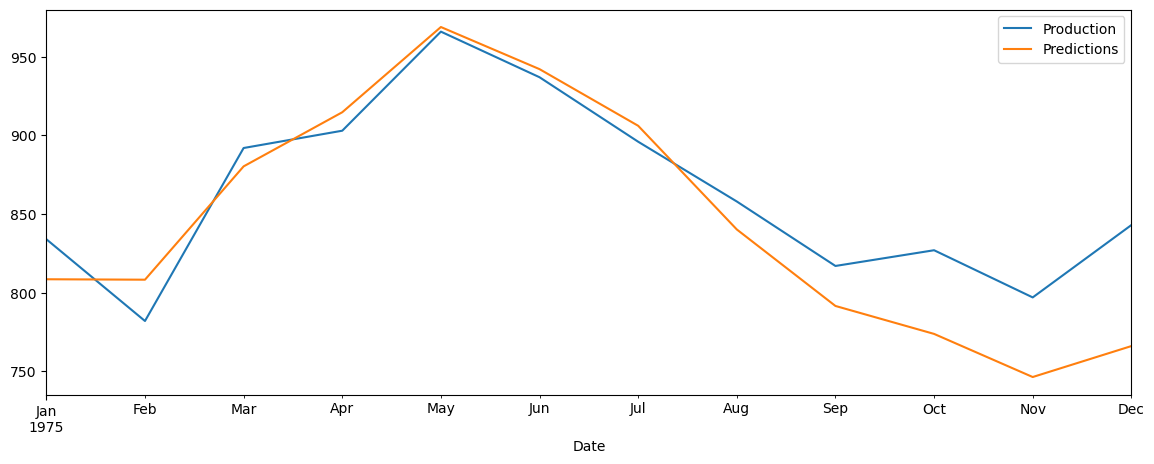

In [35]:
test.plot(figsize=(14,5))

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

34.18881512083594
